In [1]:
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from lsst.sims.featureScheduler.modelObservatory import Model_observatory
from lsst.sims.featureScheduler.schedulers import Core_scheduler
from lsst.sims.featureScheduler.utils import standard_goals, calc_norm_factor, create_season_offset
import lsst.sims.featureScheduler.basis_functions as bf
from lsst.sims.featureScheduler.surveys import (generate_dd_surveys, Greedy_survey,
                                                Blob_survey)
from lsst.sims.featureScheduler import sim_runner
import lsst.sims.featureScheduler.detailers as detailers

In [2]:
def gen_greedy_surveys(nside, nexp=1):
    """
    Make a quick set of greedy surveys
    """
    target_map = standard_goals(nside=nside)
    norm_factor = calc_norm_factor(target_map)
    # Let's remove the bluer filters since this should only be near twilight
    filters = ['r', 'i', 'z', 'y']
    surveys = []

    detailer = detailers.Camera_rot_detailer(min_rot=-87., max_rot=87.)

    for filtername in filters:
        bfs = []
        bfs.append(bf.M5_diff_basis_function(filtername=filtername, nside=nside))
        bfs.append(bf.Target_map_basis_function(filtername=filtername,
                                                target_map=target_map[filtername],
                                                out_of_bounds_val=np.nan, nside=nside,
                                                norm_factor=norm_factor))
        bfs.append(bf.Slewtime_basis_function(filtername=filtername, nside=nside))
        bfs.append(bf.Strict_filter_basis_function(filtername=filtername))
        # Masks, give these 0 weight
        bfs.append(bf.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=60., max_alt=76.))
        bfs.append(bf.Moon_avoidance_basis_function(nside=nside, moon_distance=40.))

        bfs.append(bf.Filter_loaded_basis_function(filternames=filtername))
        bfs.append(bf.Planet_mask_basis_function(nside=nside))

        weights = np.array([3.0, 0.3, 3., 3., 0., 0., 0., 0.])
        surveys.append(Greedy_survey(bfs, weights, block_size=1, filtername=filtername,
                                     dither=True, nside=nside, ignore_obs='DD', nexp=nexp,
                                     detailers=[detailer], survey_name='greedy'))

    return surveys

In [3]:
def run_sched(scheduler, survey_length=365.25, nside=32, fileroot='warm_start_example', verbose=True,
              extra_info=None, observatory=None):
    years = np.round(survey_length/365.25)
    n_visit_limit = None
    if observatory is None:
        observatory = Model_observatory(nside=nside)
    observatory, scheduler, observations = sim_runner(observatory, scheduler,
                                                      survey_length=survey_length,
                                                      filename=None,
                                                      delete_past=True, n_visit_limit=n_visit_limit,
                                                      verbose=verbose, extra_info=extra_info)
    return observatory, scheduler, observations

In [4]:
# Generate a scheduler object
nside=32
survey = gen_greedy_surveys(nside)
scheduler = Core_scheduler(survey, nside=nside)

In [5]:
# run it for a few days
observatory, scheduler, observations = run_sched(scheduler, survey_length=2.)

/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:377: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:475: RuntimeWarning: invalid value encountered in less
  slewtimes[np.where(slewtimes < 0)] = np.nan


progress = 100.05%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1247 observations
ran in 0 min = 0.0 hours
Writing results to  None


In [6]:
# Decided now we need to go to 2-snaps
new_survey = gen_greedy_surveys(nside, nexp=2)
new_scheduler = Core_scheduler(new_survey, nside=nside)
for observation in observations:
    new_scheduler.add_observation(observation)

In [7]:
# Jump ahead a few days
observatory.mjd += 3

In [8]:
# run the new scheduler
observatory, new_scheduler, new_observations = run_sched(new_scheduler, survey_length=2, observatory=observatory)

/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:377: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:475: RuntimeWarning: invalid value encountered in less
  slewtimes[np.where(slewtimes < 0)] = np.nan


progress = 100.12%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1563 observations
ran in 1 min = 0.0 hours
Writing results to  None


In [9]:
observations[0]['nexp'], new_observations[0]['nexp']

(1, 2)

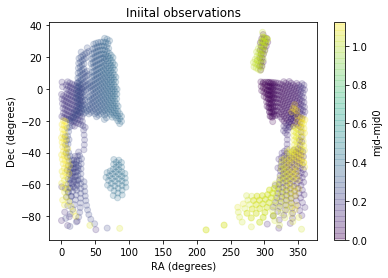

In [10]:
plt.scatter(np.degrees(observations['RA']), np.degrees(observations['dec']), c=observations['mjd']-observations['mjd'].min(), alpha=.2)
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Iniital observations')
cb = plt.colorbar()
cb.set_label('mjd-mjd0')

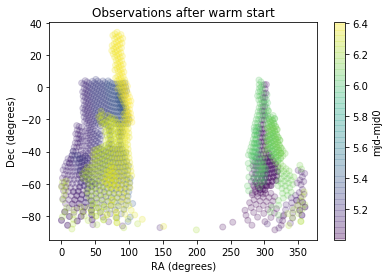

In [11]:
plt.scatter(np.degrees(new_observations['RA']), np.degrees(new_observations['dec']), c=new_observations['mjd']-observations['mjd'].min(), alpha=.2)
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Observations after warm start')
cb = plt.colorbar()
cb.set_label('mjd-mjd0')